In [1]:
import numpy as np
from aisynphys.database import default_db as db
from aisynphys.cell_class import CellClass, classify_cells, classify_pairs
from aisynphys.connectivity import measure_connectivity, pair_was_probed

In [2]:
cell_class_criteria = {
    'l2pyr': {'dendrite_type': 'spiny', 'cortical_layer': '2'},
    'l3pyr': {'dendrite_type': 'spiny', 'cortical_layer': '3'},
    'l4pyr': {'dendrite_type': 'spiny', 'cortical_layer': '4'},
    'l5pyr': {'dendrite_type': 'spiny', 'cortical_layer': '5'},
    'in':  {'dendrite_type': 'aspiny'},
}

class_labels = {
    'l2pyr':  'L2 Spiny',
    'l3pyr':  'L3 Spiny',
    'l4pyr':  'L4 Spiny',
    'l5pyr':  'L5 Spiny',
    'in':  'Aspiny',
}

cell_classes = {name:CellClass(name=name, **criteria) for name,criteria in cell_class_criteria.items()}

In [3]:
# Load all cell pairs associated with mouse V1 projects
human_pairs = db.pair_query(project_name=["human coarse matrix"]).all()

print("loaded %d cell pairs" % len(human_pairs))

loaded 10606 cell pairs


In [4]:
# Group all cells by selected classes
cell_groups = classify_cells(cell_classes.values(), pairs=human_pairs)

# Group pairs into (pre_class, post_class) groups
pair_groups = classify_pairs(human_pairs, cell_groups)

# analyze matrix elements
results = measure_connectivity(pair_groups)

In [5]:
import matplotlib.colors, matplotlib.cm
import matplotlib.pyplot as plt
from aisynphys.ui.notebook import show_connectivity_matrix


# define a colormap and log normalization used to color the heatmap
norm = matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0, clip=True)
cmap = matplotlib.cm.get_cmap('plasma')

# create a figure/axes to draw on
fig, ax = plt.subplots(figsize=(7, 7))

# finally, draw the colormap using the provided function:
im, cbar, labels = show_connectivity_matrix(
    ax=ax, 
    results=results, 
    pre_cell_classes=cell_classes.values(), 
    post_cell_classes=cell_classes.values(), 
    class_labels=class_labels, 
    cmap=cmap, 
    norm=norm
)
cbar.set_label("Connection probability", size=16)

In [6]:
pairs = db.matrix_pair_query(
    pre_classes=cell_classes,
    post_classes=cell_classes,
    pair_query_args={
        'project_name': ["human coarse matrix"],
        'synapse': True,
    },
    columns=[
        db.Synapse.psp_amplitude,
        db.Synapse.psp_rise_time,
        db.Synapse.psp_decay_tau,
        db.Synapse.psc_rise_time,
        db.Synapse.psc_decay_tau,
        db.Synapse.latency,
        db.Dynamics.stp_induction_50hz,
    ],
)


In [7]:
pairs_has_amp = pairs[~pairs['psp_amplitude'].isnull()]
psp_amp = pairs_has_amp.groupby(['pre_class', 'post_class']).aggregate(lambda x: np.mean(x))
psp_amp.head()

id  experiment_id   pre_cell_id  \
pre_class post_class                                               
in        l3pyr        88199.750000    2759.000000  15844.000000   
          l4pyr        91675.000000    2916.000000  16573.000000   
          l5pyr       114154.000000    3624.000000  20674.000000   
l2pyr     in          102171.600000    3263.400000  18527.600000   
          l2pyr        93315.441176    2924.088235  16784.529412   

                      post_cell_id  has_synapse  has_electrical  \
pre_class post_class                                              
in        l3pyr       15847.500000          1.0        0.000000   
          l4pyr       16571.000000          1.0        0.000000   
          l5pyr       20679.000000          1.0        0.000000   
l2pyr     in          18524.400000          1.0        0.000000   
          l2pyr       16783.941176          1.0        0.117647   

                      crosstalk_artifact  n_ex_test_spikes  n_in_test_spikes  \
pre_class post_class                                                           
in        l3pyr                      NaN        687.000000        315.500000   
          l4pyr                      NaN        571.000000        340.000000   
          l5pyr                      NaN        790.000000        131.000000   
l2pyr     in                         NaN        574.200000         24.000000   
          l2pyr                      NaN        675.970588        143.411765   

                      distance  meta  psp_amplitude  psp_rise_time  \
pre_class post_class                                                 
in        l3pyr       0.000184   NaN      -0.000200       0.005186   
          l4pyr       0.000086   NaN      -0.000221       0.004706   
          l5pyr       0.000131   NaN      -0.000006       0.014138   
l2pyr     in          0.000112   NaN       0.001473       0.002255   
          l2pyr       0.000102   NaN       0.000314       0.005622   

                      psp_decay_tau  psc_rise_time  psc_decay_tau   latency  \
pre_class post_class                                                          
in        l3pyr            0.162793       0.001608       0.005173  0.001445   
          l4pyr            0.046958       0.000100       0.034499  0.000904   
          l5pyr            0.293728       0.002596       0.005420  0.001985   
l2pyr     in               0.009874       0.001181       0.001586  0.001416   
          l2pyr            0.047326       0.003161       0.005293  0.002703   

                      stp_induction_50hz  
pre_class post_class                      
in        l3pyr                -0.310723  
          l4pyr                -0.142874  
          l5pyr                 0.187793  
l2pyr     in                   -0.379990  
          l2pyr                -0.230709

/home/luke/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


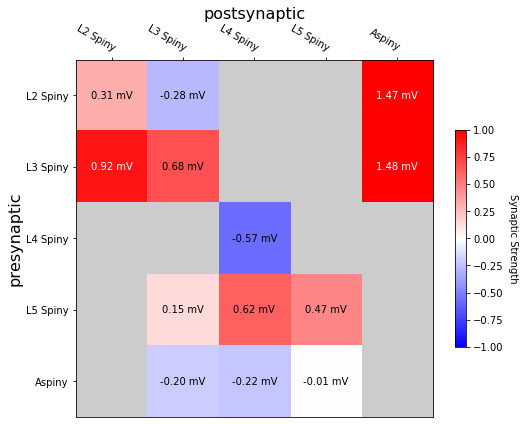

In [8]:
from aisynphys.ui.notebook import heatmap, annotate_heatmap
import matplotlib.colors, matplotlib.cm
import matplotlib.pyplot as plt
%matplotlib inline

cmap = matplotlib.cm.get_cmap('bwr')
norm = matplotlib.colors.Normalize(vmin=-1, vmax=1, clip=False)

shape = (len(cell_classes), len(cell_classes))
data = np.zeros(shape)
data_alpha = np.zeros(shape)
data_str = np.zeros(shape, dtype=object)

for i, pre_class in enumerate(cell_classes):
    for j, post_class in enumerate(cell_classes):
        try:
            value = psp_amp.loc[pre_class].loc[post_class].psp_amplitude
        except KeyError:
            value = np.nan
        data[i, j] = value*1e3
        data_str[i, j] = "%0.2f mV" % (value*1e3) if np.isfinite(value) else ""
        data_alpha[i, j] = 1 if np.isfinite(value) else 0 
        
labels = [class_labels[cls] for cls in cell_classes]
mapper = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
data_rgb = mapper.to_rgba(data)
data_rgb[:,:,3] = np.clip(data_alpha, 0, 1)

strength_fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(data_rgb, labels, labels,
                  ax=ax,
                  ax_labels=('postsynaptic', 'presynaptic'),
                  bg_color=(0.8, 0.8, 0.8),
                  cmap=cmap,
                  norm=norm,
                  cbarlabel='Synaptic Strength',
                  cbar_kw={'shrink':0.5})

text = annotate_heatmap(im, data_str, data=data)

In [9]:
fname = 'C:\\Users\\stephanies\\aisynphys\\analyses\\figures\\Fig3A_strength_matrix.svg'
strength_fig.savefig(fname)

In [10]:
excitatory_labels = ['l2pyr', 'l3pyr', 'l4pyr', 'l5pyr']
inhibitory_labels = ['in']

all_amps = pairs_has_amp['psp_amplitude']
ee_amps = pairs_has_amp[pairs_has_amp['pre_class'].isin(excitatory_labels) 
                            & pairs_has_amp['post_class'].isin(excitatory_labels)]['psp_amplitude']
ei_amps = pairs_has_amp[pairs_has_amp['pre_class'].isin(excitatory_labels) 
                            & pairs_has_amp['post_class'].isin(inhibitory_labels)]['psp_amplitude']
ie_amps = pairs_has_amp[pairs_has_amp['pre_class'].isin(inhibitory_labels) 
                            & pairs_has_amp['post_class'].isin(excitatory_labels)]['psp_amplitude']
ii_amps = pairs_has_amp[pairs_has_amp['pre_class'].isin(inhibitory_labels) 
                            & pairs_has_amp['post_class'].isin(inhibitory_labels)]['psp_amplitude']

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.,
        0., 1., 2., 1., 2., 1., 0., 0., 0., 2., 0., 0., 0.]),
 array([-3.00000000e+00, -2.80000000e+00, -2.60000000e+00, -2.40000000e+00,
        -2.20000000e+00, -2.00000000e+00, -1.80000000e+00, -1.60000000e+00,
        -1.40000000e+00, -1.20000000e+00, -1.00000000e+00, -8.00000000e-01,
        -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,  2.66453526e-15,
         2.00000000e-01,  4.00000000e-01,  6.00000000e-01,  8.00000000e-01,
         1.00000000e+00,  1.20000000e+00,  1.40000000e+00,  1.60000000e+00,
         1.80000000e+00,  2.00000000e+00,  2.20000000e+00,  2.40000000e+00,
         2.60000000e+00,  2.80000000e+00,  3.00000000e+00]),
 <a list of 30 Patch objects>)

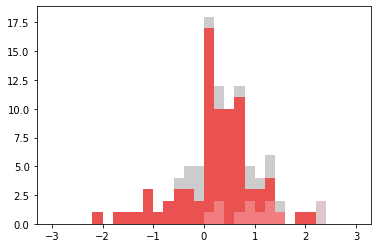

In [11]:
bin_edges = np.arange(-3, 3.1, 0.2)

hist1, ax = plt.subplots()
ax.hist(all_amps*1e3, bins=bin_edges, color=(0.8, 0.8, 0.8))

ax.hist(ee_amps*1e3, bins=bin_edges, color='red', alpha=0.6)
ax.hist(ei_amps*1e3, bins=bin_edges, color='pink', alpha=0.4)

In [12]:
fname = 'C:\\Users\\stephanies\\aisynphys\\analyses\\figures\\Fig3B_hist.svg'
hist1.savefig(fname)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-3.00000000e+00, -2.80000000e+00, -2.60000000e+00, -2.40000000e+00,
        -2.20000000e+00, -2.00000000e+00, -1.80000000e+00, -1.60000000e+00,
        -1.40000000e+00, -1.20000000e+00, -1.00000000e+00, -8.00000000e-01,
        -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,  2.66453526e-15,
         2.00000000e-01,  4.00000000e-01,  6.00000000e-01,  8.00000000e-01,
         1.00000000e+00,  1.20000000e+00,  1.40000000e+00,  1.60000000e+00,
         1.80000000e+00,  2.00000000e+00,  2.20000000e+00,  2.40000000e+00,
         2.60000000e+00,  2.80000000e+00,  3.00000000e+00]),
 <a list of 30 Patch objects>)

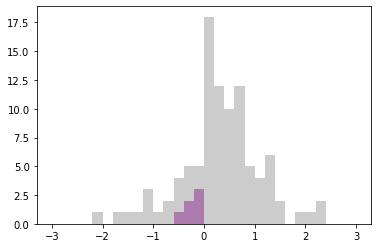

In [13]:
hist2, ax = plt.subplots()
ax.hist(all_amps*1e3, bins=bin_edges, color=(0.8, 0.8, 0.8))

ax.hist(ii_amps*1e3, bins=bin_edges, color='blue', alpha=0.4)
ax.hist(ie_amps*1e3, bins=bin_edges, color='purple', alpha=0.4)

In [14]:
fname = 'C:\\Users\\stephanies\\aisynphys\\analyses\\figures\\Fig3C_hist.svg'
hist2.savefig(fname)

In [15]:
field = 'psc_rise_time'

pairs_has_rt = pairs[~pairs[field].isnull()]
psp_rise = pairs_has_rt.groupby(['pre_class', 'post_class']).aggregate(lambda x: np.mean(x))
psp_rise.head()

id  experiment_id   pre_cell_id  \
pre_class post_class                                               
in        in           52469.000000    1537.000000   9108.000000   
          l2pyr       120352.000000    3819.000000  21814.000000   
          l3pyr        88028.166667    2748.833333  15797.833333   
          l4pyr       102480.000000    3255.000000  18543.500000   
          l5pyr       114156.500000    3624.000000  20674.000000   

                      post_cell_id  has_synapse  has_electrical  \
pre_class post_class                                              
in        in                9106.0          1.0             0.0   
          l2pyr            21807.0          1.0             0.0   
          l3pyr            15801.5          1.0             0.0   
          l4pyr            18537.0          1.0             0.0   
          l5pyr            20679.5          1.0             0.0   

                      crosstalk_artifact  n_ex_test_spikes  n_in_test_spikes  \
pre_class post_class                                                           
in        in                         NaN        643.000000        132.000000   
          l2pyr                      NaN        778.000000         60.000000   
          l3pyr                      NaN        619.833333        346.166667   
          l4pyr                      NaN        548.500000        399.500000   
          l5pyr                      NaN        791.000000        131.500000   

                      distance  meta  psp_amplitude  psp_rise_time  \
pre_class post_class                                                 
in        in          0.000113   NaN            NaN       0.004630   
          l2pyr       0.000530   NaN            NaN       0.008212   
          l3pyr       0.000152   NaN      -0.000200       0.005640   
          l4pyr       0.000074   NaN      -0.000221       0.006157   
          l5pyr       0.000082   NaN      -0.000006       0.014006   

                      psp_decay_tau  psc_rise_time  psc_decay_tau   latency  \
pre_class post_class                                                          
in        in               0.006350       0.001485       0.007547       NaN   
          l2pyr            0.500000       0.002725       0.030796       NaN   
          l3pyr            0.156556       0.001774       0.006004  0.001329   
          l4pyr            0.051977       0.001666       0.018668  0.000904   
          l5pyr            0.305767       0.004257       0.009630  0.001985   

                      stp_induction_50hz  
pre_class post_class                      
in        in                         NaN  
          l2pyr                      NaN  
          l3pyr                -0.310723  
          l4pyr                -0.142874  
          l5pyr                 0.187793

/home/luke/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/colors.py:1108: RuntimeWarning: invalid value encountered in less_equal
  mask = (resdat <= 0)


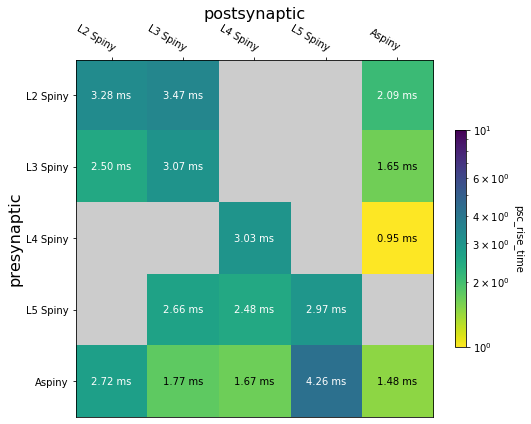

In [16]:
cmap = matplotlib.cm.get_cmap('viridis_r')
norm = matplotlib.colors.LogNorm(vmin=1, vmax=10, clip=False)

shape = (len(cell_classes), len(cell_classes))
data = np.zeros(shape)
data_alpha = np.zeros(shape)
data_str = np.zeros(shape, dtype=object)

for i, pre_class in enumerate(cell_classes):
    for j, post_class in enumerate(cell_classes):
        try:
            value = getattr(psp_rise.loc[pre_class].loc[post_class], field)
        except KeyError:
            value = np.nan
        data[i, j] = value*1e3
        data_str[i, j] = "%0.2f ms" % (value*1e3) if np.isfinite(value) else ""
        data_alpha[i, j] = 1 if np.isfinite(value) else 0 
        
labels = [class_labels[cls] for cls in cell_classes]
mapper = matplotlib.cm.ScalarMappable(cmap=cmap, norm=norm)
data_rgb = mapper.to_rgba(data)
data_rgb[:,:,3] = np.clip(data_alpha, 0, 1)

rise_time_fig, ax = plt.subplots(figsize=(8,8))
im, cbar = heatmap(data_rgb, labels, labels,
                  ax=ax,
                  ax_labels=('postsynaptic', 'presynaptic'),
                  bg_color=(0.8, 0.8, 0.8),
                  cmap=cmap,
                  norm=norm,
                  cbarlabel=field,
                  cbar_kw={'shrink':0.5})

text = annotate_heatmap(im, data_str, data=data)

In [17]:
# Download and cache the sqlite file for the requested database
#   (for available versions, see SynphysDatabase.list_versions)
#db = SynphysDatabase.load_version('synphys_r1.0_2019-08-29_small.sqlite')

# Load all synapses associated with mouse V1 projects
pairs = db.pair_query(
    project_name=["human coarse matrix"],
    synapse=True,
).all()

print("loaded %d synapses" % len(pairs))

loaded 390 synapses


In [18]:
# get a list of all cells in the selected pairs
cells = set([pair.pre_cell for pair in pairs] + [pair.post_cell for pair in pairs])

# Classify each cell. Note that, depending on the class definitions above, a cell could 
# belong to multiple classes. 
cell_class = {}
for cell in cells:
    # which of the classes defined above is this cell a member of?
    cell_in_classes = [cls_name for cls_name, cls in cell_classes.items() if cell in cls]
    cell_class[cell] = ','.join(cell_in_classes)

In [19]:
import pandas

# construct a pandas dataframe containing the pre/postsynaptic cell class names
# and a measure of short-term plasticity
pre_class = [cell_class[pair.pre_cell] for pair in pairs]
post_class = [cell_class[pair.post_cell] for pair in pairs]
stp = [None if pair.dynamics is None else pair.dynamics.stp_induction_50hz for pair in pairs]

df = pandas.DataFrame(
    zip(pairs, pre_class, post_class, stp), 
    columns=['pair', 'pre_class', 'post_class', 'stp']) 

# select out only cells that are a member of exactly 1 class
mask = df.pre_class.isin(cell_classes) & df.post_class.isin(cell_classes)
df = df[mask]

# select only pairs with a measured stp
df = df.dropna()

df.head()

,pair,pre_class,post_class,stp
6,<Pair 1534394748.497 4 7>,l5pyr,l3pyr,-0.400713
26,<Pair 1548200410.746 3 5>,l3pyr,l3pyr,-0.594401
37,<Pair 1507690323.707 5 6>,l3pyr,in,-0.811485
38,<Pair 1520997064.505 5 4>,l3pyr,l3pyr,-0.615449
49,<Pair 1507690323.707 5 3>,l3pyr,l3pyr,-0.177132


In [20]:
stp = df.pivot_table('stp', 'pre_class', 'post_class', aggfunc=np.nanmean)

# sort rows/cols into the expected order
order = list(cell_classes)
stp = stp[order].loc[order]

stp

post_class,l2pyr,l3pyr,l4pyr,l5pyr,in
pre_class,,,,,
l2pyr,-0.230709,-0.326183,NaN,NaN,-0.379990
l3pyr,-0.300080,-0.401134,NaN,NaN,-0.558059
l4pyr,NaN,NaN,0.084660,NaN,NaN
l5pyr,NaN,-0.400713,NaN,-0.376016,NaN
in,NaN,-0.310723,-0.142874,0.187793,NaN


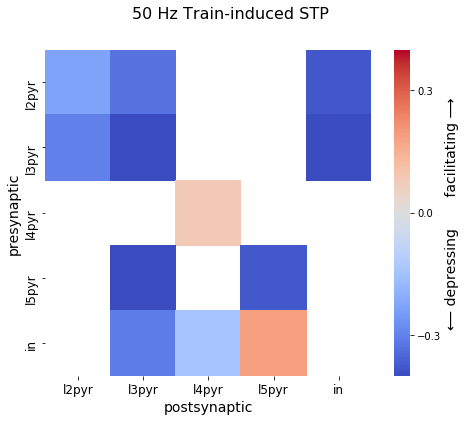

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fig,ax = plt.subplots(figsize=(8, 6))

hm = sns.heatmap(stp, cmap='coolwarm', vmin=-0.4, vmax=0.4, square=True, ax=ax,
                cbar_kws={"ticks":[-0.3, 0, 0.3], 'label': '⟵ depressing       facilitating ⟶'})

fig.suptitle("50 Hz Train-induced STP", fontsize=16)
hm.set_xlabel("postsynaptic", fontsize=14)
hm.set_ylabel("presynaptic", fontsize=14);
hm.figure.axes[-1].yaxis.label.set_size(14)
hm.tick_params(labelsize=12)

In [22]:
# query once for each postsynaptic type, building up a Pandas dataframe

pairs = None
# pair_classes = [
#     ('l23pyr', 'l23pyr'),
#     ('l23pyr', 'vip'),
    
#     ('l4pyr', 'sst'),
    
#     ('l5et', 'l5et'),
#     ('l5et', 'pv'),

#     ('l6pyr', 'pv'),
#     ('l6pyr', 'sst'),
    
#     ('pv', 'l5et'),
#     ('pv', 'l5it'),
    
#     ('sst', 'l6pyr'),
#     ('sst', 'vip'),
    
#     ('vip', 'l23pyr'),
#     ('vip', 'vip'),
# ]

pair_classes = [
    ('l2pyr', 'l2pyr'),
    ('l3pyr', 'l3pyr'),
    #('l4pyr', 'l4pyr'),
    ('l3pyr', 'in'),
    ('l2pyr', 'in'),
]    
for pre_name, post_name in pair_classes:
    pre_class = cell_classes[pre_name]
    post_class = cell_classes[post_name]
    pair_query = db.pair_query(
        project_name=["human coarse matrix"],
        pre_class=pre_class,
        post_class=post_class,
        synapse=True,
    )
    pair_query = pair_query.add_columns(
        db.Synapse.psp_amplitude,
        db.Synapse.latency,
        db.Synapse.psc_rise_time,
        db.Dynamics.pulse_amp_90th_percentile,
        db.Dynamics.stp_initial_50hz,
        db.Dynamics.stp_induction_50hz,
        db.Dynamics.stp_recovery_250ms,
    )
    
    df = pair_query.dataframe()
    df['pre_class'] = pre_name
    df['post_class'] = post_name
    df['pair_class'] = pre_name + "→" + post_name
    if pairs is None:
        pairs = df
    else:
        pairs = pairs.append(df)
    print("%s->%s: %d synapses" % (pre_name, post_name, len(df)))

l2pyr->l2pyr: 60 synapses
l3pyr->l3pyr: 43 synapses
l3pyr->in: 9 synapses
l2pyr->in: 9 synapses


In [23]:
np.nanmean(pairs[pairs['pair_class']=="in→l5pyr"]['stp_induction_50hz'])

/home/luke/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


nan

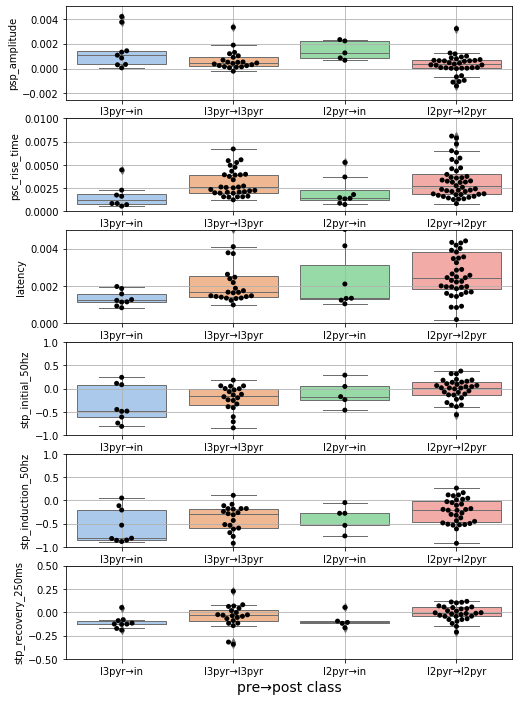

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

limits = {
    'psp_amplitude': (-2.5e-3, 5.0e-3),
    'psc_rise_time': (0, 10e-3),
    'latency': (0, 5e-3),
    #'pulse_amp_90th_percentile': (-5.0e-3, 5.0e-3),
    'stp_initial_50hz': (-1.0, 1.0),
    'stp_induction_50hz': (-1.0, 1.0),
    'stp_recovery_250ms': (-0.5, 0.5),
}
units = ['ms', 'ms', 'ms', 'mV']
ticks = {
    'ms': 0.5e-3 * 2**np.arange(4),
    'mV': 20e-6 * 4**np.arange(4),
}

stp_mean = pairs.groupby('pair_class').mean()['stp_initial_50hz']
order = stp_mean.argsort()
index_order = stp_mean.index[order]

fig,ax = plt.subplots(len(limits), 1, figsize=(8, 2.0 * len(limits)))


for i, (field, lim) in enumerate(limits.items()):
    # box and swarm plots
    #ax[i].set_yscale('log')
    ax[i].set_ylim(*lim)
    sns.boxplot(x="pair_class", y=field, data=pairs, order=index_order, ax=ax[i], palette='pastel', width=0.8, linewidth=1)
    sns.swarmplot(x="pair_class", y=field, data=pairs, order=index_order, ax=ax[i], size=5, color=(0, 0, 0, 0.5))
    
    # clean up labels / ticks
    if i == len(limits)-1:
        ax[i].set_xlabel('pre→post class', size=14)
    else:
        ax[i].set_xlabel('')
    #ax[i].set_ylabel(field.replace('_', ' ') + ' (%s)'%units[i], size=12)
    #ax[i].set_yticks(ticks[units[i]])
    #ax[i].set_yticklabels(['%0.2f' % (x*1000) for x in ticks[units[i]]])
    ax[i].set_yticklabels([], minor=True)
    ax[i].grid()